# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
19762,27871,72823,"Durham, England",26-03-2020,So I think itÃÂs fair to say weÃÂre all a ...,Negative
24048,33193,78145,"Fort Bend County, TX",05-04-2020,While I disagree with activists #churches bein...,Positive
19755,27861,72813,"Beaumont, Texas",26-03-2020,"Madison's, a bar/restaurant in #Beaumont, pivo...",Positive
15144,22229,67181,Bristol,23-03-2020,@kxgrave2002 @MaggieRae20 @PHE_uk @DLapthorne ...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [3]:
df["Sentiment"].value_counts()

Sentiment
Positive              11422
Negative               9917
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [4]:
df["Sentiment"] = df["Sentiment"].map({"Positive": 1, "Negative": 0, "Extremely Positive": 1, "Extremely Negative": 0})
df["Sentiment"].unique()

array([1, 0])

Сбалансированы ли классы?

In [5]:
df["Sentiment"].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

In [6]:
df["Sentiment"].value_counts(normalize=True)

Sentiment
1    0.539589
0    0.460411
Name: proportion, dtype: float64

**Ответ:** классы сбалансированы, примерно 50% положительных и 50% отрицательных твитов. 

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [7]:
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Пропуски присутствуют только в столбце Location. Заполним их строкой 'Unknown'.

In [8]:
df["Location"].fillna("Unknown", inplace=True)
df.isna().sum()

/var/folders/7m/_s2dd8053g97sjss_c0260mc0000gn/T/ipykernel_17513/488821534.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Location"].fillna("Unknown", inplace=True)


UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

In [10]:
print(train.shape)
train["Sentiment"].value_counts(normalize=True)

(23410, 6)


Sentiment
1    0.536694
0    0.463306
Name: proportion, dtype: float64

In [11]:
print(test.shape)
test["Sentiment"].value_counts(normalize=True)

(10034, 6)


Sentiment
1    0.546342
0    0.453658
Name: proportion, dtype: float64

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

На самом деле можно использовать метод `str.split()`, но его минус в том, что он никак не обрабатывает пунктуацию. Знаки препинания остаются склеенными с токенами, поэтому в словаре будут встречаться одинаковые токены с разным окончанием, что может повлечь плачевные последствия. Поэтому будем пользоваться похожим на стандартный `str.split()` `word_tokenize()` из библиотеки `nltk`. Он отделяет токены от знаков препинания, но не удаляет их. 

In [12]:
# Подготовка
import nltk
from nltk import word_tokenize
nltk.download("punkt_tab", quiet=True)

True

In [13]:
from collections import Counter

tokens = [word_tokenize(text) for text in train["OriginalTweet"]]
len(tokens)

23410

In [14]:
count = Counter([word.lower() for text in tokens for word in text])

Какой размер словаря получился?

In [15]:
raw_tokenizer_len = len(count)
raw_tokenizer_len

57256

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [16]:
count.most_common(10)

[('#', 42753),
 ('the', 26928),
 ('to', 23466),
 ('.', 23220),
 (',', 17556),
 (':', 16478),
 ('and', 14792),
 ('of', 13043),
 ('https', 12921),
 ('a', 11835)]

**Ответ:** заметим, что в десятке самых популярных токенов встречается много знаков пунктуации и стоп-слов (слов, которые не несут никакой смысловой нагрузки). Это достаточно очевидно, ведь в каждом осмысленном и грамотном предложении присутствуют знаки препинания, а также предлоги, союзы и т.д., суммарно по всем текстам их количество будет очень большим. 

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [17]:
# Подготовка
from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)

True

In [18]:
for stopword in stopwords.words("english"):
    if stopword in count:
        del count[stopword]
len(count)

57107

In [19]:
count.most_common(10)

[('#', 42753),
 ('.', 23220),
 (',', 17556),
 (':', 16478),
 ('https', 12921),
 ('?', 11033),
 ('coronavirus', 9965),
 ('@', 9959),
 ('!', 4700),
 ('prices', 4618)]

**Ответ:** Итак, получаем уже более осмысленный топ-10 токенов, в котором среди множества знаков препинания можно найти и слова, которые несут смысловую нагрузку. Очевидно, что эти слова являются **ключевыми** (соответствующими тематике твитов). Среди них *coronavirus* и *prices*.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [20]:
count.most_common()[-20:]

[('//t.co/lw1r0rm7xs', 1),
 ('//t.co/5cbliqzx7l', 1),
 ('now.when', 1),
 ('milion', 1),
 ('skellig', 1),
 ('skelligsix18', 1),
 ('skelligcoast2kms', 1),
 ('southkerry', 1),
 ('//t.co/zjcl195vqs', 1),
 ('srinivasiyc', 1),
 ('//t.co/iaek4fwsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã\x82â\x92', 1),
 ('renewing', 1),
 ('flew', 1),
 ('torontopearson', 1),
 ('680news', 1),
 ('//t.co/7j2y3rsld9', 1)]

**Ответ:** среди 20 самых непопулярных слов можно найти много url-адресов. Каждый из них имеет домен `t.co` — домен сокрощателя ссылок, который используется в твитах. В адресе указывается сокрощенный адрес, который является уникальным для каждого твита, пользователя и т.д. Возможно, что некоторые из этих адресов ведут на другие твиты, которые являются предметом обсуждения текущего твита или ответом на него. Самый простой выход — удалить все эти токены из словаря, так как они не несут никакой смысловой нагрузки, интересное решение — рекурсивно обойти все ссылки и учитывать найденные в них токены. Понятно, что сейчас мы таким заниматься не будем, но звучит интересно. 

Также встречаются и странные "склеенные" слова. Скорее всего, они получились из хэштегов или просто тэгов после отбрасывания знаков препинания при `word_tokenize()`. В принципе хэштэги широко используются в твитах, они используются многими пользователями, чтобы объединить твиты по определенной теме, поэтому их необходимо учитывать. 



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [21]:
from nltk.tokenize import TweetTokenizer

# preseve_case=False - не учитывать регистр
# там еще есть несколько интересных параметров, хочется тоже потом попробовать
# https://www.nltk.org/_modules/nltk/tokenize/casual.html#TweetTokenizer.__init__
tw = TweetTokenizer(preserve_case=False)

In [22]:
count = Counter([word for text in train["OriginalTweet"] for word in tw.tokenize(text)])
len(count)

58350

In [23]:
count.most_common(10)

[('the', 26993),
 ('.', 24118),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

**Ответ:** до сих пор лидируют знаки препинания и стоп-слова, однако из списка пропал `#`, так как `TweetTokenizer` оставляет знак решетки перед соответствующим хэштегом. По той же причине пропали `@` и `https`. Освободилось место для самого популярного среди твитов про коронавируса хэштега `#coronavirus`.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [24]:
noises = stopwords.words("english") + list(punctuation)
for noise in noises:
    if noise in count:
        del count[noise]
len(count)

58129

In [25]:
count.most_common(10)

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** да, в топ-10 встречаются токены, обозначающие неотображаемые символы, такие как `\x82` и `\x82`.

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [26]:
for ordr in range(128, 256):
    if chr(ordr) in count:
        del count[chr(ordr)]
len(count)

58089

In [27]:
count.most_common(10)

[('#coronavirus', 8808),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805),
 ('grocery', 3523),
 ('people', 3463),
 ('#covid19', 2589)]

In [28]:
count.most_common()[-20:]

[('https://t.co/LW1r0Rm7XS', 1),
 ('https://t.co/5cBLIqZX7L', 1),
 ('now.when', 1),
 ('milion', 1),
 ('skellig', 1),
 ('@skelligsix18', 1),
 ('#skelligcoast2kms', 1),
 ('#southkerry', 1),
 ('https://t.co/zJcL195VQS', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/IAEK4fWsgz', 1),
 ('premiership', 1),
 ('non-playing', 1),
 ('subsidise', 1),
 ('playersã', 1),
 ('renewing', 1),
 ('flew', 1),
 ('@torontopearson', 1),
 ('@680news', 1),
 ('https://t.co/7j2Y3rSld9', 1)]

**Ответ:** мы не проверяли топ-10 для токенизации по пробелам с удалением пунктуации (остановились только на стоп-словах), но можно детально сравнить топ-20 наименее популярных токенов с разными токенизациями. `TweetTokenizer` учитывает специфику твитов, оставляя необходимые для понимания символы, такие как `#` и `@`, сохраняя валидные ссылки, что нельзя сказать о токенизации по пробелам.

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [29]:
hashtags_count = Counter({key: value for key, value in count.items() if key.startswith("#")})
hashtags_count.most_common(10)

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

**Ответ:** ранее уже было замечено, что тематические (про коронавирус) хэштеги, такие как `#coronavirus`, `#covid19` и т.п. будут встречаться чаще всего. Также в топ-10 попал хэштэг `toiletpaper`, который стал мемом в начале пандемии, когда люди начали скупать туалетную бумагу.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [30]:
tcolinks_count = Counter({key: value for key, value in count.items() if key.startswith("https://t.co")})
tcolinks_count.most_common(10)

[('https://t.co/oXA7SWtoNd', 5),
 ('https://t.co/gP3EusapL8', 4),
 ('https://t.co/DefTruI1PfÃ\x82Â', 3),
 ('https://t.co/WrLHYzIzAA', 3),
 ('https://t.co/kuwIpF1KQW', 3),
 ('https://t.co/zjNRx6dKKN', 3),
 ('https://t.co/3GBBDpdjat', 3),
 ('https://t.co/e2ZNXajPre', 3),
 ('https://t.co/CATKegAyOY', 3),
 ('https://t.co/G63RP042HO', 3)]

**Ответ:** ссылки на сайт `t.co` встречаются реже, чем хэштеги. Это связано с тем, что ссылки на сайт `t.co` являются сокращенными ссылками, которые ведут на другие страницы. В то время как хэштеги используются для объединения твитов по определенной теме. Также, скорее всего, несколько `t.co` ссылок могут вести на одну и ту же страницу, что делает их менее информативными.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [31]:
def custom_tokenizer(text):
  # не учитываем регистр
  tw = TweetTokenizer(preserve_case=False)

  tw_tokens = tw.tokenize(text)

  def check(word):
    if len(word) == 1 and ord(word) > 127:
      return False
    if word in stopwords.words("english"):
      return False
    if word in punctuation:
      return False
    if word.startswith("https://t.co"):
      return False
    return True

  return list(filter(check, tw_tokens))


In [32]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(train["OriginalTweet"])

print(len(cv.vocabulary_))

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45290


In [34]:
raw_tokenizer_len / len(cv.vocabulary_)

1.2642084345330096

**Ответ:** размер словаря уменьшился примерно в 1.25 раза. Это связано с тем, что в словаре остались только токены, которые несут смысловую нагрузку.

Посмотрим на какой-нибудь конкретный твитт:

In [35]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [36]:
features = cv.get_feature_names_out()
tweetX = cv.transform([train.iloc[ind]['OriginalTweet']])

best = np.argmax(tweetX)
print("Best", features[best])
print("vocabulary[best] =", cv.vocabulary_[features[best]])

Best #coronavirusoutbreak
vocabulary[best] = 1833


In [37]:
without_zero_tweetX = tweetX[(tweetX > 0).toarray()]
without_zero_features = features[(tweetX > 0).toarray()[0]]

worst = np.argmin(without_zero_tweetX)
print("Worst", without_zero_features[worst])
print("vocabulary[worst] =", cv.vocabulary_[without_zero_features[worst]])

Worst #coronavirusoutbreak
vocabulary[worst] = 1833


In [38]:
without_zero_tweetX

matrix([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

**Ответ:** как можно заметить самый важный токен совпадает с самым незначительным токеном. Так происходит потому, что в тексте каждое слово встречается только один раз, а векторизация `CountVectorizer` учитывает лишь количество встреч токена в тексте. Выше показан пример того, как выглядят ненулевые значения в векторе. Именно поэтому самый важный и неважный токены здесь определяются плохо. Да и в целом хэштэг `#coronavirusoutbreak` никак не поможет понять, что твит негативный.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf.fit(train["OriginalTweet"])
print(len(tfidf.vocabulary_))

45290


In [40]:
features = tfidf.get_feature_names_out()
tweetX = tfidf.transform([train.iloc[ind]['OriginalTweet']])
best = np.argmax(tweetX)
print("Best", features[best])
print("vocabulary[best] =", tfidf.vocabulary_[features[best]])

Best brainless
vocabulary[best] = 20553


In [41]:
without_zero_tweetX = tweetX[(tweetX > 0).toarray()]
without_zero_features = features[(tweetX > 0).toarray()[0]]

worst = np.argmin(without_zero_tweetX)
print("Worst", without_zero_features[worst])
print("vocabulary[worst] =", cv.vocabulary_[without_zero_features[worst]])

Worst food
vocabulary[worst] = 27042


**Ответ:** Гораздо лучше!!! Исходя из логики: токен `brainless` явно указывает на негативный твит, можно сказать, что он является самым важным. А вот токен `food` несет гораздо меньше информации о твите, так как он не указывает на его эмоциональную окраску. Возвращаясь к TF-IDF: слово `brainless` встречается в данном тексте чаще, чем в остальных, поэтому оно важнее для этого текста (в мерках TF-IDF). А вот слово `food` встречается в этом тексте так же, как и в остальных, поэтому оно менее важно для этого текста.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [42]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
3281,7772,52724,"Nairobi, Kenya",18-03-2020,Crisp clean fresh air perfect ambience Covid 1...,1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


Возьмем позитивный твит про магазин Waitrose с индексом 24347.

In [43]:
tweet = train.loc[24347]
tweet["OriginalTweet"]

'Massive thanks to @waitrose for my delivery of my online food shopping, you two delivery drivers were amazing &amp; excellent customer service skills, not sure why I stopped having you delivery my shopping, I will be having you deliver every week once I can once #coronavirus is over'

In [44]:
features = tfidf.get_feature_names_out()
tweetX = tfidf.transform([tweet["OriginalTweet"]])
best = np.argmax(tweetX)
print("Best", features[best])
print("vocabulary[best] =", tfidf.vocabulary_[features[best]])

Best delivery
vocabulary[best] = 23960


**Ответ:** действительно, токен `delivery` важен в этом твите, так как он непосредственно указывает на тематику твита.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [45]:
X_train, y_train = train.drop(columns=["Sentiment"]), train["Sentiment"]
X_test, y_test = test.drop(columns=["Sentiment"]), test["Sentiment"]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((23410, 5), (23410,), (10034, 5), (10034,))

In [46]:
cv_vec_train = cv.fit_transform(X_train["OriginalTweet"])
cv_vec_test = cv.transform(X_test["OriginalTweet"])

tfidf_vec_train = tfidf.fit_transform(X_train["OriginalTweet"])
tfidf_vec_test = tfidf.transform(X_test["OriginalTweet"])

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [48]:
cv_logreg = LogisticRegression(max_iter=1000)
cv_logreg.fit(cv_vec_train, y_train)

print("Train accuracy:", accuracy_score(y_train, cv_logreg.predict(cv_vec_train)))
print("Test accuracy:", accuracy_score(y_test, cv_logreg.predict(cv_vec_test)))

Train accuracy: 0.9846646732165741
Test accuracy: 0.8670520231213873


In [49]:
tfidf_logreg = LogisticRegression(max_iter=1000)
tfidf_logreg.fit(tfidf_vec_train, y_train)

print("Train accuracy:", accuracy_score(y_train, tfidf_logreg.predict(tfidf_vec_train)))
print("Test accuracy:", accuracy_score(y_test, tfidf_logreg.predict(tfidf_vec_test)))

Train accuracy: 0.9224263135412217
Test accuracy: 0.85280047837353


**Ответ:** обе модели показали хорошие результаты, но, что удивительно для автора, модель с `CountVectorizer` показала лучший результат. Однако, на тестовой выборке модель с `CountVectorizer` показала результат 0.98, что может говорить о переобучении модели.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [50]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer("english")
  tokens = custom_tokenizer(text)
  return [stemmer.stem(token) for token in tokens]

In [51]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [52]:
cv_stemming = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv_stemming.fit(X_train["OriginalTweet"])

print(len(cv_stemming.vocabulary_))

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36634


Найдем, во сколько раз уменьшился размер словаря. 

In [53]:
len(cv.vocabulary_) / len(cv_stemming.vocabulary_)

1.2362832341540646

In [54]:
tfidf_stemming = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_stemming.fit(X_train["OriginalTweet"])

print(len(tfidf_stemming.vocabulary_))

36634


**Ответ:** ожидаемо размер словаря уменьшился при использовании стемминга, причем примерно в 1.25 раза. Это связано с тем, что стемминг приводит слова к их основе, что позволяет уменьшить размер словаря.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [55]:
cv_stemming_vec_train = cv_stemming.fit_transform(X_train["OriginalTweet"])
cv_stemming_vec_test = cv_stemming.transform(X_test["OriginalTweet"])

tfidf_stemming_vec_train = tfidf_stemming.fit_transform(X_train["OriginalTweet"])
tfidf_stemming_vec_test = tfidf_stemming.transform(X_test["OriginalTweet"])

In [56]:
cv_stemming_logreg = LogisticRegression(max_iter=1000)
cv_stemming_logreg.fit(cv_stemming_vec_train, y_train)

print("Train accuracy:", accuracy_score(y_train, cv_stemming_logreg.predict(cv_stemming_vec_train)))
print("Test accuracy:", accuracy_score(y_test, cv_stemming_logreg.predict(cv_stemming_vec_test)))

Train accuracy: 0.9720205040580948
Test accuracy: 0.8674506677297189


In [57]:
tfidf_stemming_logreg = LogisticRegression(max_iter=1000)
tfidf_stemming_logreg.fit(tfidf_stemming_vec_train, y_train)

print("Train accuracy:", accuracy_score(y_train, tfidf_stemming_logreg.predict(tfidf_stemming_vec_train)))
print("Test accuracy:", accuracy_score(y_test, tfidf_stemming_logreg.predict(tfidf_stemming_vec_test)))

Train accuracy: 0.9165741136266553
Test accuracy: 0.8559896352401833


In [58]:
results = pd.DataFrame(columns=["Train accuracy", "Test accuracy"], 
              index=["CountVectorizer", "TfidfVectorizer", "CountVectorizer + Stemming", "TfidfVectorizer + Stemming"],
              data=[[accuracy_score(y_train, cv_logreg.predict(cv_vec_train)), accuracy_score(y_test, cv_logreg.predict(cv_vec_test))],
                    [accuracy_score(y_train, tfidf_logreg.predict(tfidf_vec_train)), accuracy_score(y_test, tfidf_logreg.predict(tfidf_vec_test))],
                    [accuracy_score(y_train, cv_stemming_logreg.predict(cv_stemming_vec_train)), accuracy_score(y_test, cv_stemming_logreg.predict(cv_stemming_vec_test))],
                    [accuracy_score(y_train, tfidf_stemming_logreg.predict(tfidf_stemming_vec_train)), accuracy_score(y_test, tfidf_stemming_logreg.predict(tfidf_stemming_vec_test))]])
results

,Train accuracy,Test accuracy
CountVectorizer,0.984665,0.867052
TfidfVectorizer,0.922426,0.852800
CountVectorizer + Stemming,0.972021,0.867451
TfidfVectorizer + Stemming,0.916574,0.855990


**Ответ:** наблюдается совсем небольшое улучшение accuracy на тестовой выборке, но на обучающей выборке наоборот — ухудшение. В целом можно сказать, что стемминг в нашем случае не сильно влияет на качество модели, но не исключено, что в других случаях он может помочь.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

Так как изначально у меня не 36651 токен, а 36634, будем добиваться на один меньше, то есть 36633.

In [59]:
# Смотрим, сколько всего текстов
df.shape

(33444, 6)

In [60]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=10000,
                        ).fit(
                            X_train["OriginalTweet"]
                            )
print(len(cv_df.vocabulary_))

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36634


Слишком большой параметр, так как в словаре по прежнему 36634 токена.

In [61]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7000,
                        ).fit(
                            X_train["OriginalTweet"]
                            )
print(len(cv_df.vocabulary_))

36633


In [62]:
set(cv_stemming.vocabulary_) - set(cv_df.vocabulary_)

{'#coronavirus'}

Видим, что при найденном параметре max_df перестает учитываться токен `#coronavirus`.

**Ответ:** не пришлось долго перебирать, значение нашлось почти сразу. Параметр получился большим, так как в словаре самый популярный токен `#coronavirus` встречался очень часто.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [63]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=10
                        ).fit(
                            X_train["OriginalTweet"]
                            )
print(len(cv_df.vocabulary_))

3918


Становится понятно, в какую сторону двигаться. Переберем значения.

In [64]:
from tqdm import tqdm

for test_value in tqdm(range(11, 25)):
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                            min_df=test_value
                            ).fit(
                                X_train["OriginalTweet"]
                                )
    if len(cv_df.vocabulary_) <= 3700:
        print("min_df =", test_value)
        print("len(cv_df.vocabulary_) =", len(cv_df.vocabulary_))
        break

  0%|          | 0/14 [48:10<?, ?it/s]

min_df = 11
len(cv_df.vocabulary_) = 3687


Ровно 3700 токенов не получилось и не получится, так как количество токенов монотонно убывает при увеличении min_df, а пограничное значение — 11 (при min_df = 10 токенов 3918, слишком много).

Проверим, не потеряли ли мы качество модели.

In [65]:
cv_df_vec_train = cv_df.fit_transform(X_train["OriginalTweet"])
cv_df_vec_test = cv_df.transform(X_test["OriginalTweet"])

cv_df_logreg = LogisticRegression(max_iter=1000)
cv_df_logreg.fit(cv_df_vec_train, y_train)

print("Train accuracy:", accuracy_score(y_train, cv_df_logreg.predict(cv_df_vec_train)))
print("Test accuracy:", accuracy_score(y_test, cv_df_logreg.predict(cv_df_vec_test)))


Train accuracy: 0.9290046988466467
Test accuracy: 0.8680486346422165


In [66]:
results = pd.concat([
    results,
    pd.DataFrame([[accuracy_score(y_train, cv_df_logreg.predict(cv_df_vec_train)), accuracy_score(y_test, cv_df_logreg.predict(cv_df_vec_test))]], columns=["Train accuracy", "Test accuracy"], index=["CountVectorizer + min_df"]),
])
results

,Train accuracy,Test accuracy
CountVectorizer,0.984665,0.867052
TfidfVectorizer,0.922426,0.852800
CountVectorizer + Stemming,0.972021,0.867451
TfidfVectorizer + Stemming,0.916574,0.855990
CountVectorizer + min_df,0.929005,0.868049


**Ответ:** на 3700 токенах качество модели немного улучшилось на тестовой выборке, но ухудшилось на обучающей. Это может говорить о том, что мы избавились от переобучения на обучающей выборке.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cv_df_vec_train_scaled = scaler.fit_transform(cv_df_vec_train.toarray())
cv_df_vec_test_scaled = scaler.transform(cv_df_vec_test.toarray())

cv_df_logreg_scaled = LogisticRegression(max_iter=1000)
cv_df_logreg_scaled.fit(cv_df_vec_train_scaled, y_train)

print("Train accuracy:", accuracy_score(y_train, cv_df_logreg_scaled.predict(cv_df_vec_train_scaled)))
print("Test accuracy:", accuracy_score(y_test, cv_df_logreg_scaled.predict(cv_df_vec_test_scaled)))

Train accuracy: 0.9412217001281503
Test accuracy: 0.8446282639027307


In [68]:
results = pd.concat([
    results,
    pd.DataFrame([[accuracy_score(y_train, cv_df_logreg_scaled.predict(cv_df_vec_train_scaled)), accuracy_score(y_test, cv_df_logreg_scaled.predict(cv_df_vec_test_scaled))]], columns=["Train accuracy", "Test accuracy"], index=["CountVectorizer + min_df + scaling"]),
])
results

,Train accuracy,Test accuracy
CountVectorizer,0.984665,0.867052
TfidfVectorizer,0.922426,0.852800
CountVectorizer + Stemming,0.972021,0.867451
TfidfVectorizer + Stemming,0.916574,0.855990
CountVectorizer + min_df,0.929005,0.868049
CountVectorizer + min_df + scaling,0.941222,0.844628


accuracy модели ухудшилось на обеих выборках после скалирования.

In [69]:
cv_df_logreg_scaled.coef_[0]

array([-0.00621504, -0.00331929,  0.06919367, ...,  0.00173393,
        0.01264062,  0.01037631])

In [70]:
barplot_df = pd.DataFrame(cv_df_logreg_scaled.coef_[0], index=cv_df.get_feature_names_out(), columns=["coef"])
barplot_df.sort_values("coef", ascending=False, inplace=True)
barplot_df.head(10)

,coef
hand,1.236936
free,1.113360
help,1.076927
thank,1.038253
like,0.928429
best,0.910603
pleas,0.839764
great,0.811614
safe,0.786677
support,0.731159


Text(0, 0.5, 'Coefficient')

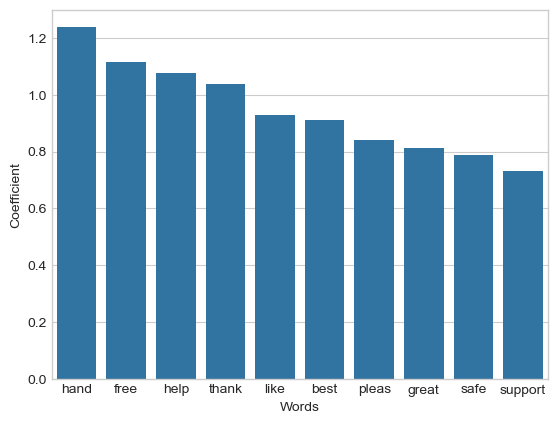

In [71]:
ax = sns.barplot(data=barplot_df.head(10), x=barplot_df.head(10).index, y="coef")
ax.set_xlabel("Words")
ax.set_ylabel("Coefficient")

Text(0, 0.5, 'Coefficient')

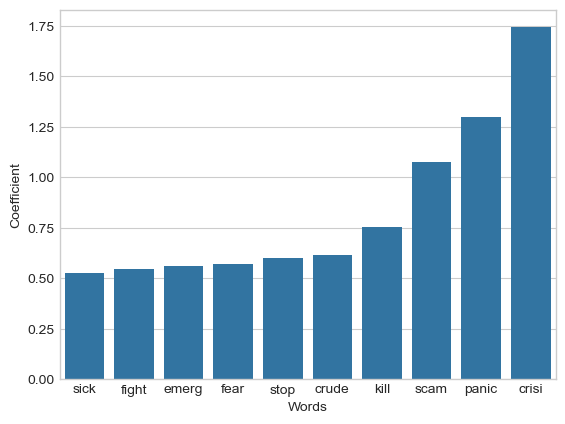

In [72]:
ax = sns.barplot(data=np.abs(barplot_df.tail(10)), x=barplot_df.tail(10).index, y="coef")
ax.set_xlabel("Words")
ax.set_ylabel("Coefficient")

**Ответ:** токены с наибольшими положительными весами указывают на позитивные (положительно окрашенные) твиты, а токены с наибольшими отрицательными весами — на негативные твиты. Действительно, среди положительных токенов можно найти `free`, `great`, `best`, а среди отрицательных — `panic`, `scam`, `kill`. Наличие таких токенов в твите может указывать на его эмоциональную окраску.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [73]:
df.shape

(33444, 6)

In [74]:
df["UserName"].nunique()

33444

In [75]:
df["ScreenName"].nunique()

33444

**Ответ:** количество уникальных имен пользователей и отображаемых имен пользователей совпадает с количеством твитов, что говорит о том, что каждый твит был написан уникальным пользователем. Поэтому эти признаки играют роль идентификаторов и не несут никакой смысловой нагрузки.

Выбросим эти признаки из `X_train` и `X_test`.

In [76]:
X_train, X_test = X_train.drop(columns=["UserName", "ScreenName"]), X_test.drop(columns=["UserName", "ScreenName"])
X_train.shape, X_test.shape

((23410, 3), (10034, 3))

In [77]:
X_train.head()

,Location,TweetAt,OriginalTweet
25621,Unknown,06-04-2020,Why we still want to buy so much stuff during ...
30135,"Boston, MA HQ",10-04-2020,With driving even more usage a strong strategy...
28899,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...
5989,"Mayfair, London, UK",19-03-2020,The U.S national debt will likely exceed $30 T...
4367,WNC,18-03-2020,"Finally got to the grocery store. Honestly, wh..."


Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [78]:
X_train["TweetAt"] = pd.to_datetime(X_train["TweetAt"], format="%d-%m-%Y")
X_train["TweetAt"].head()

25621   2020-04-06
30135   2020-04-10
28899   2020-04-09
5989    2020-03-19
4367    2020-03-18
Name: TweetAt, dtype: datetime64[ns]

In [79]:
X_train["TweetAt"].nunique()

30

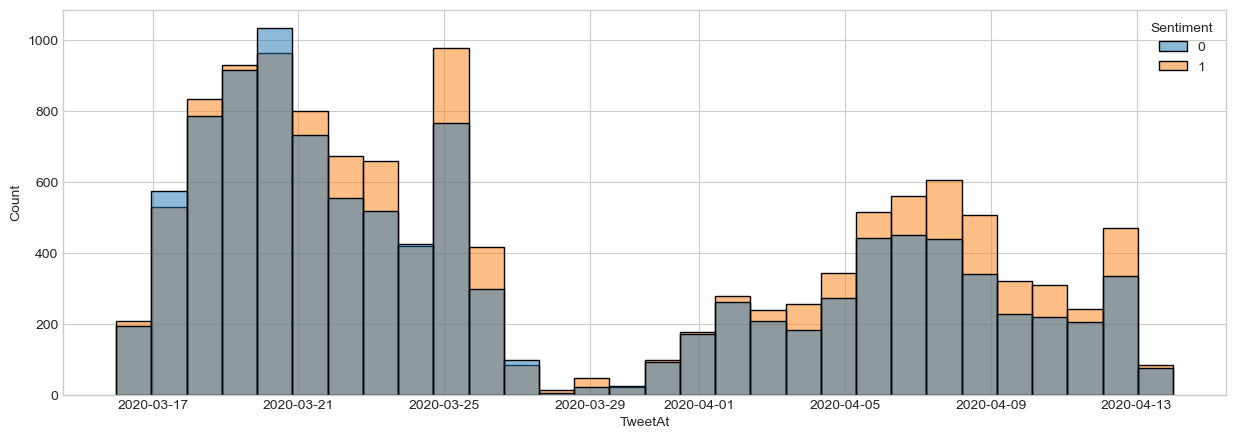

In [80]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=pd.concat([X_train, y_train], axis=1), x="TweetAt", hue="Sentiment", bins=30, ax=ax);

**Ответ:** почти в каждый из дней положительные твиты преобладают над отрицательными. Из-за этого данный признак будет мало полезен для классификации твитов по эмоциональной окраске. Исключим его из `X_train` и `X_test`.

In [81]:
X_train, X_test = X_train.drop(columns=["TweetAt"]), X_test.drop(columns=["TweetAt"])
X_train.shape, X_test.shape

((23410, 2), (10034, 2))

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [82]:
locations = X_train["Location"].value_counts()
locations

Location
Unknown                           4944
London                             301
United States                      295
London, England                    274
New York, NY                       223
                                  ... 
Work: Kent and Live: Sussex          1
Somewhere on TradingView             1
Honolulu, Hawai?i                    1
SFO                                  1
Waterville, Ireland Austin, TX       1
Name: count, Length: 7949, dtype: int64

In [83]:
X_train["Location"].nunique()

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

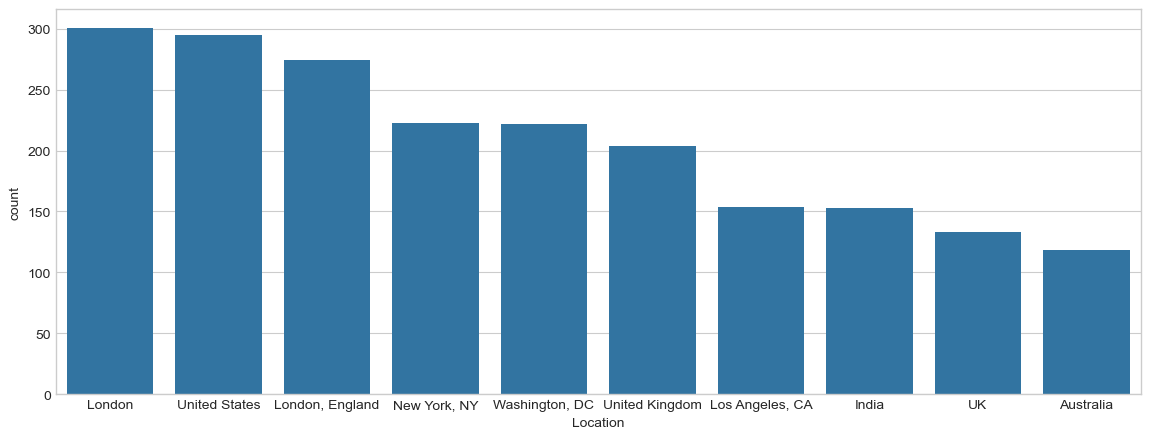

In [84]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(data=locations.drop("Unknown").head(10), ax=ax);

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [85]:
def wider_location(location: str) -> str:
    splitted = location.split(", ")
    return splitted[-1]

X_train["WiderLocation"], X_test["WiderLocation"] = X_train["Location"].apply(wider_location), X_test["Location"].apply(wider_location)
wider_locations = X_train["WiderLocation"].value_counts()
wider_locations

WiderLocation
Unknown                    4944
USA                         950
England                     860
CA                          597
India                       535
                           ... 
The DC & The OC               1
UK - Europe                   1
not Drumpf's Reich USSR       1
iowa                          1
NIGERIA                       1
Name: count, Length: 4921, dtype: int64

In [86]:
X_train["WiderLocation"].nunique()

4921

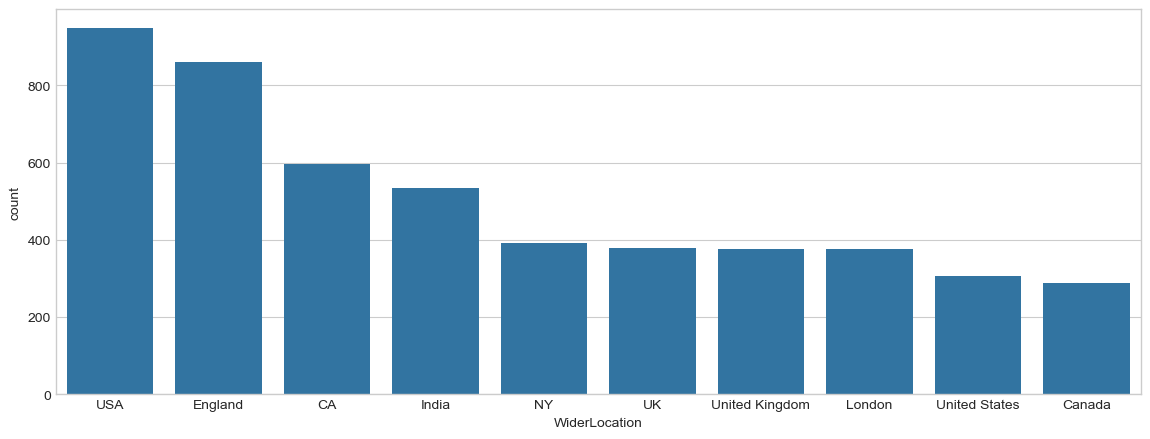

In [87]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(data=wider_locations.drop("Unknown").head(10), ax=ax);

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [89]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(
    sparse_output=False,
    handle_unknown="ignore",
    categories=[wider_locations[wider_locations > 1].index.drop("Unknown").tolist()]
)

In [90]:
X_train_wider_locations = ohe.fit_transform(X_train[["WiderLocation"]])
X_test_wider_locations = ohe.transform(X_test[["WiderLocation"]])
X_train_wider_locations.shape, X_test_wider_locations.shape

((23410, 1009), (10034, 1009))

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [91]:
X_train, X_test = np.hstack([cv_df_vec_train_scaled, X_train_wider_locations]), np.hstack([cv_df_vec_test_scaled, X_test_wider_locations])

In [92]:
locations_logreg = LogisticRegression(max_iter=1000)
locations_logreg.fit(X_train, y_train)

print("Train accuracy:", accuracy_score(y_train, locations_logreg.predict(X_train)))
print("Test accuracy:", accuracy_score(y_test, locations_logreg.predict(X_test)))

Train accuracy: 0.9447671935070483
Test accuracy: 0.8443292804464819


In [93]:
results = pd.concat([
    results,
    pd.DataFrame([[accuracy_score(y_train, locations_logreg.predict(X_train)), accuracy_score(y_test, locations_logreg.predict(X_test))]], columns=["Train accuracy", "Test accuracy"], index=["CountVectorizer + min_df + WiderLocation"]),
])
results

,Train accuracy,Test accuracy
CountVectorizer,0.984665,0.867052
TfidfVectorizer,0.922426,0.852800
CountVectorizer + Stemming,0.972021,0.867451
TfidfVectorizer + Stemming,0.916574,0.855990
CountVectorizer + min_df,0.929005,0.868049
CountVectorizer + min_df + scaling,0.941222,0.844628
CountVectorizer + min_df + WiderLocation,0.944767,0.844329


**Ответ:** accuracy модели почти не изменилось: небольшой прирост на обучающей выборке и небольшой спад на тестовой. Это может говорить о том, что признак не особо информативен.

/var/folders/7m/_s2dd8053g97sjss_c0260mc0000gn/T/ipykernel_17513/255163933.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30);


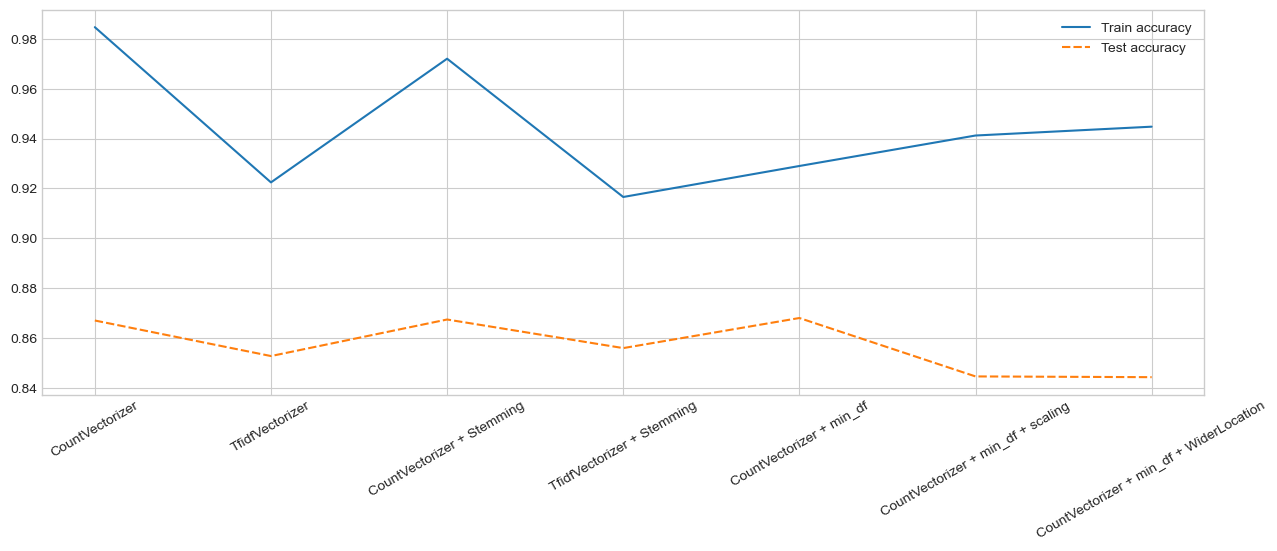

In [99]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=results, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

По итогу получили, что лучший accuracy на тестовой выборке был достигнут при использовании `CountVectorizer` с параметром `min_df=11` и стеммингом.